In [1]:
%load_ext lab_black

In [51]:
import pandas as pd
import numpy as np
from scipy.special import expit, logit

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [92]:
from sklearn.metrics import roc_auc_score, brier_score_loss
from sklearn.linear_model import LogisticRegression

In [137]:
import lightgbm as lgb

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [6]:
from weight_of_evidence import weight_of_evidence

In [7]:
import importlib

importlib.reload(weight_of_evidence)

<module 'weight_of_evidence.weight_of_evidence' from '/Users/olivercairns/Desktop/code/WeightOfEvidenceDemo/weight_of_evidence/weight_of_evidence.py'>

In [8]:
np.random.seed = 1234

In [104]:
company_age = np.arange(1, 100, 0.01)

In [123]:
linear_log_odds = (company_age - company_age.mean()) / company_age.std()

In [124]:
linear_risk = expit(linear_log_odds)

In [125]:
non_linear_risk = expit(linear_log_odds ** 5)

In [126]:
def non_mono_fn(company_age):
    if company_age <= 25:
        return 0.25
    elif company_age <= 75:
        return 0.75
    else:
        return 0.25

In [127]:
non_mono_vec = np.vectorize(non_mono_fn)

In [128]:
non_mono_risk = non_mono_vec(company_age)

In [129]:
SCENARIOS = [
    (linear_risk, "linear"),
    (non_linear_risk, "non-linear"),
    (non_mono_risk, "non-monotonic"),
]

In [130]:
linear_risk.shape

(9900,)

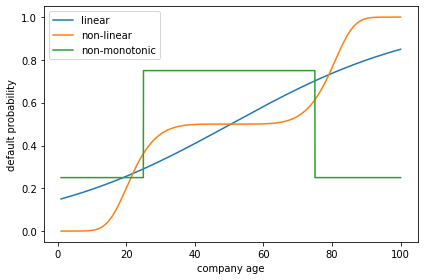

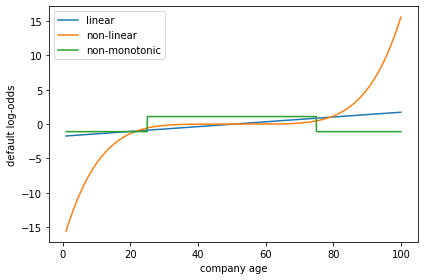

In [178]:
for t in ["probability", "log-odds"]:
    if t == "probability":
        plt.plot(company_age, linear_risk)
        plt.plot(company_age, non_linear_risk)
        plt.plot(company_age, non_mono_risk)
    else:
        plt.plot(company_age, logit(linear_risk))
        plt.plot(company_age, logit(non_linear_risk))
        plt.plot(company_age, logit(non_mono_risk))
    plt.legend(["linear", "non-linear", "non-monotonic"])
    plt.xlabel("company age")
    plt.ylabel(f"default {t}")
    plt.tight_layout()
    plt.savefig(f"admin/age_vs_risk_{t}.png")
    plt.show()

In [132]:
log_reg = LogisticRegression(solver="lbfgs")

In [138]:
MODELS = (
    ("lightgbm", lgb.LGBMClassifier()),
    ("log reg", LogisticRegression(solver="lbfgs")),
)

In [160]:
results = {"scenario": [], "auc": [], "brier": [], "model": []}
for risk_vector, scenario_name in SCENARIOS:
    for model_name, classifier in MODELS:
        for _ in range(10):
            y_train = simulate_outcome(risk_vector)
            y_test = simulate_outcome(risk_vector)
            X = np.array([company_age]).T
            classifier.fit(X, y_train)
            y_pred = classifier.predict_proba(X)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
            brier = brier_score_loss(y_test, y_pred)
            results["scenario"].append(scenario_name)
            results["brier"].append(brier)
            results["auc"].append(auc)
            results["model"].append(model_name)

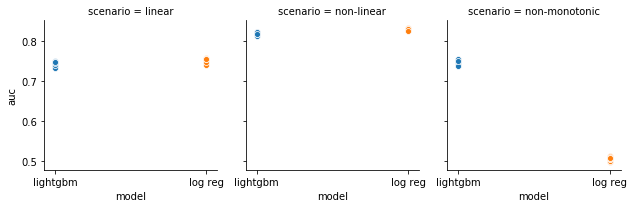

In [161]:
g = sns.FacetGrid(data=pd.DataFrame(results), col="scenario", hue="model")
g.map(sns.scatterplot, "model", "auc")

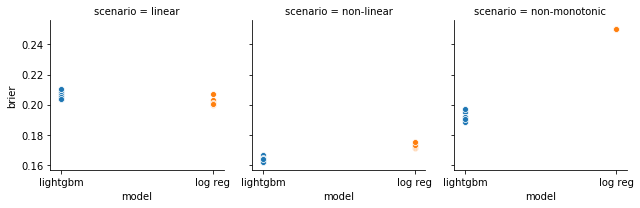

In [162]:
g = sns.FacetGrid(data=pd.DataFrame(results), col="scenario", hue="model")
g.map(sns.scatterplot, "model", "brier")

In [163]:
tree_binner = weight_of_evidence.TreeBinner(max_depth=2)

In [164]:
y_train = simulate_outcome(non_mono_risk)
y_test = simulate_outcome(non_mono_risk)

In [165]:
X = pd.DataFrame(data=X, columns=["company_age"])

In [166]:
y_train = pd.Series(y_train)

In [167]:
X_binned = tree_binner.fit_transform(X, y_train)

In [168]:
X_binned.company_age.unique()

array(['(-inf, 2.05]', '(2.05, 75.0]', '(75.0, inf]'], dtype=object)

In [169]:
logit_scaler = weight_of_evidence.LogitScaler()

In [170]:
X_scaled = logit_scaler.fit_transform(X_binned, y_train)

In [171]:
logit_scaler.logit_values_

{'company_age': {'(-inf, 2.05]': -0.5411309732613196,
  '(2.05, 75.0]': 0.34639729281134035,
  '(75.0, inf]': -1.0938161164046165}}

In [172]:
woebin_logit = Pipeline(
    steps=[
        ("tree_bin", weight_of_evidence.TreeBinner(max_depth=2)),
        ("logit_scale", weight_of_evidence.LogitScaler()),
        ("standard_scale", StandardScaler()),
        ("log_reg_classifier", LogisticRegression(solver="lbfgs")),
    ]
)

In [173]:
for risk_vector, scenario_name in SCENARIOS:
    for _ in range(10):
        y_train = pd.Series(simulate_outcome(risk_vector))
        y_test = simulate_outcome(risk_vector)
        X = np.array([company_age]).T
        X = pd.DataFrame(data=X, columns=["company_age"])

        woebin_logit.fit(X, y_train)
        y_pred = woebin_logit.predict_proba(X)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        brier = brier_score_loss(y_test, y_pred)

        results["scenario"].append(scenario_name)
        results["auc"].append(auc)
        results["brier"].append(brier)
        results["model"].append("woebinned log reg")

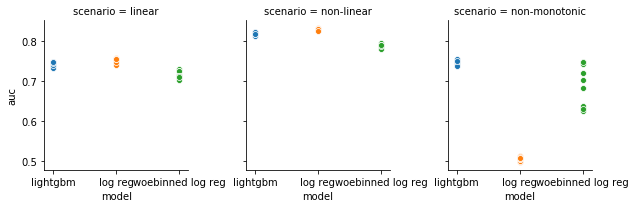

In [174]:
g = sns.FacetGrid(data=pd.DataFrame(results), col="scenario", hue="model")
g.map(sns.scatterplot, "model", "auc")

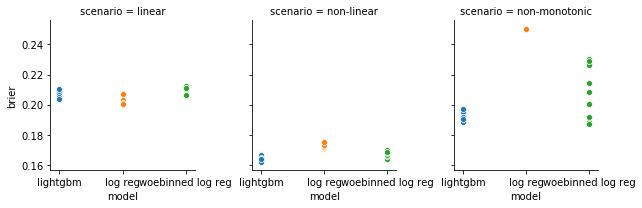

In [176]:
g = sns.FacetGrid(data=pd.DataFrame(results), col="scenario", hue="model")
g.map(sns.scatterplot, "model", "brier")

In [177]:
pd.DataFrame(results).groupby(["scenario", "model"])[["auc", "brier"]].mean()

auc     brier
scenario      model                                
linear        lightgbm           0.742663  0.206156
              log reg            0.753356  0.201766
              woebinned log reg  0.715578  0.209178
non-linear    lightgbm           0.820281  0.163754
              log reg            0.829347  0.173531
              woebinned log reg  0.788667  0.167562
non-monotonic lightgbm           0.749240  0.191619
              log reg            0.505222  0.249996
              woebinned log reg  0.687060  0.210218